In [2]:
import pandas
import math
import numpy
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import chi2, f_classif, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import pearsonr, spearmanr
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import statistics
from skorch.dataset import CVSplit
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler
from xgboost import XGBClassifier

In [3]:
data = pandas.read_csv('/home/vladimir/MachineLearning/Projects/Titanic/train.csv')

In [4]:
data = data.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [198]:
data.describe()

Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

In [199]:
data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [200]:
values = {'Age': data['Age'].mean(skipna=True), 'Embarked': data['Embarked'].mode(dropna=True)[0]}

In [201]:
data.fillna(value=values, inplace = True)

In [202]:
#Number of bins: square root choice
N = round(math.sqrt(data.shape[0]))

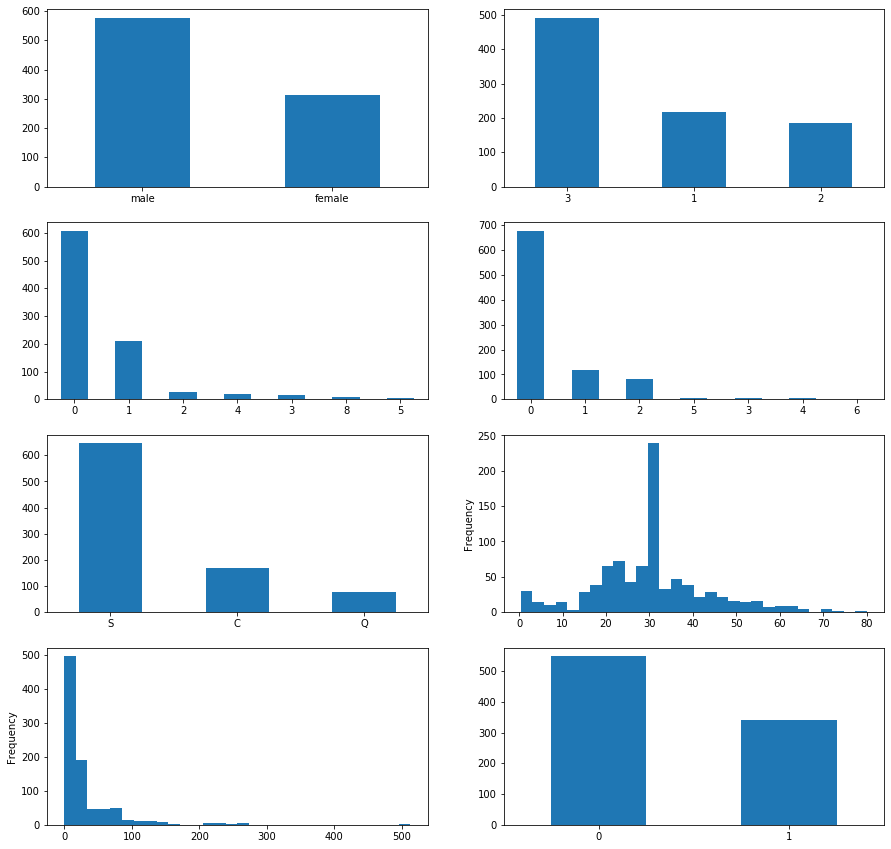

In [203]:
#fig, ax = plt.subplots()
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,15))
data['Sex'].value_counts().plot.bar(ax=axes[0,0], rot=0)
data['Pclass'].value_counts().plot.bar(ax=axes[0,1], rot=0)
data['SibSp'].value_counts().plot.bar(ax=axes[1,0], rot=0)
data['Parch'].value_counts().plot.bar(ax=axes[1,1], rot=0)
data['Embarked'].value_counts().plot.bar(ax=axes[2,0], rot=0)
data['Age'].plot.hist(ax=axes[2,1], rot=0, bins=N)
data['Fare'].plot.hist(ax=axes[3,0], rot=0, bins=N)
data['Survived'].value_counts().plot.bar(ax=axes[3,1], rot=0)

In [204]:
label_encoding = {'Sex': {'male': 0, 'female': 1},
                 'Embarked': {'C': 0, 'Q': 1, 'S': 2}}

In [205]:
data.replace(label_encoding, inplace=True)

In [206]:
data.head()

Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    0  22.0      1      0   7.2500         2
1         1       1    1  38.0      1      0  71.2833         0
2         1       3    1  26.0      0      0   7.9250         2
3         1       1    1  35.0      1      0  53.1000         2
4         0       3    0  35.0      0      0   8.0500         2

In [207]:
X = data[['Age', 'Fare']].to_numpy()
y = data['Survived'].to_numpy()
regr = SelectKBest(f_classif, k='all')
regr.fit(X,y)
print(regr.pvalues_, regr.scores_)

NameError: name 'SelectKBest' is not defined

In [208]:
X = data[['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']].to_numpy()
y = data['Survived'].to_numpy()
regr = chi2(X, y)
print(regr[1])

[6.21058490e-39 2.75378563e-08 1.40248517e-03 1.08094210e-01
 1.48470676e-03]


In [209]:
regr = [chi2(X, data[i].to_numpy()) for i in ['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']]
print(regr)

[(array([577.        ,   4.68827211,   4.25327175,  27.19151962,
        91.32390467]), array([1.68517374e-127, 3.03691717e-002, 3.91747897e-002, 1.84265150e-007,
       1.21978140e-021])), (array([ 10.99052186, 269.47593583,  24.55316924,  17.76404674,
         0.52723502]), array([4.10618490e-03, 3.04820402e-59, 4.65958291e-06, 1.38862910e-04,
       7.68267338e-01])), (array([  8.3648967 ,  25.37442237, 362.88531775,   9.95143853,
        10.82607823]), array([1.52610972e-02, 3.09039642e-06, 1.58655258e-79, 6.90355166e-03,
       4.45807102e-03])), (array([  28.32772407,   12.89448486,    5.97845915, 2069.33476395,
        284.85148925]), array([8.15055424e-05, 4.47424734e-02, 4.25607433e-01, 0.00000000e+00,
       1.43724356e-58])), (array([  39.08371803,    2.14377459,    2.17500714,  542.47724304,
       1515.37647059]), array([6.89216951e-007, 9.06011973e-001, 9.02919970e-001, 5.90797616e-114,
       0.00000000e+000]))]


In [210]:
data[['Age','Fare']].corr(method='spearman')

Age      Fare
Age   1.000000  0.118847
Fare  0.118847  1.000000

In [211]:
spearmanr(data['Fare'], data['Age'])

SpearmanrResult(correlation=0.11884708066033668, pvalue=0.0003777382373651246)

In [212]:
data = pandas.get_dummies(data, columns=['Sex', 'Embarked', 'Pclass'])
#data = data.drop(columns=['Sex_male', 'Embarked_S', 'Pclass_3'])


In [213]:
data.head()

Survived   Age  SibSp  Parch     Fare  Sex_0  Sex_1  Embarked_0  \
0         0  22.0      1      0   7.2500      1      0           0   
1         1  38.0      1      0  71.2833      0      1           1   
2         1  26.0      0      0   7.9250      0      1           0   
3         1  35.0      1      0  53.1000      0      1           0   
4         0  35.0      0      0   8.0500      1      0           0   

   Embarked_1  Embarked_2  Pclass_1  Pclass_2  Pclass_3  
0           0           1         0         0         1  
1           0           0         1         0         0  
2           0           1         0         0         1  
3           0           1         1         0         0  
4           0           1         0         0         1

In [214]:
data.drop(columns=['Sex_1', 'Embarked_2', 'Pclass_3'], inplace=True)

In [215]:
data.head()

Survived   Age  SibSp  Parch     Fare  Sex_0  Embarked_0  Embarked_1  \
0         0  22.0      1      0   7.2500      1           0           0   
1         1  38.0      1      0  71.2833      0           1           0   
2         1  26.0      0      0   7.9250      0           0           0   
3         1  35.0      1      0  53.1000      0           0           0   
4         0  35.0      0      0   8.0500      1           0           0   

   Pclass_1  Pclass_2  
0         0         0  
1         1         0  
2         0         0  
3         1         0  
4         0         0

In [216]:
test = pandas.read_csv('/home/vladimir/MachineLearning/Projects/Titanic/test.csv')
pass_id = test['PassengerId']

In [217]:
pass_id = pass_id.to_numpy().tolist()

In [218]:
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [219]:
test.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'],  inplace=True)

In [220]:
test.head()

Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  34.5      0      0   7.8292        Q
1       3  female  47.0      1      0   7.0000        S
2       2    male  62.0      0      0   9.6875        Q
3       3    male  27.0      0      0   8.6625        S
4       3  female  22.0      1      1  12.2875        S

In [221]:
test.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [222]:
values = {'Age': test['Age'].mean(skipna=True), 'Fare': test['Fare'].mean(skipna=True)}
test.fillna(value=values, inplace = True)

In [223]:
test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [224]:
test.replace(label_encoding, inplace=True)

In [225]:
test.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    0  34.5      0      0   7.8292         1
1       3    1  47.0      1      0   7.0000         2
2       2    0  62.0      0      0   9.6875         1
3       3    0  27.0      0      0   8.6625         2
4       3    1  22.0      1      1  12.2875         2

In [226]:
test = pandas.get_dummies(test, columns=['Sex', 'Embarked', 'Pclass'])

In [227]:
test.head()

Age  SibSp  Parch     Fare  Sex_0  Sex_1  Embarked_0  Embarked_1  \
0  34.5      0      0   7.8292      1      0           0           1   
1  47.0      1      0   7.0000      0      1           0           0   
2  62.0      0      0   9.6875      1      0           0           1   
3  27.0      0      0   8.6625      1      0           0           0   
4  22.0      1      1  12.2875      0      1           0           0   

   Embarked_2  Pclass_1  Pclass_2  Pclass_3  
0           0         0         0         1  
1           1         0         0         1  
2           0         0         1         0  
3           1         0         0         1  
4           1         0         0         1

In [228]:
test.drop(columns=['Sex_1', 'Embarked_2', 'Pclass_3'], inplace=True)

In [229]:
test.head()

Age  SibSp  Parch     Fare  Sex_0  Embarked_0  Embarked_1  Pclass_1  \
0  34.5      0      0   7.8292      1           0           1         0   
1  47.0      1      0   7.0000      0           0           0         0   
2  62.0      0      0   9.6875      1           0           1         0   
3  27.0      0      0   8.6625      1           0           0         0   
4  22.0      1      1  12.2875      0           0           0         0   

   Pclass_2  
0         0  
1         0  
2         1  
3         0  
4         0

In [230]:
#Logistic Regression

clf = LogisticRegression(max_iter=200)
clf.fit(data.loc[:, 'Age':], data['Survived'])
clf.score(data.loc[:, 'Age':], data['Survived'])

0.8047138047138047

In [189]:
#Random Forest

clf = RandomForestClassifier(max_depth=3, random_state=0)
#clf.fit(data.loc[:, 'Age':], data['Survived'])
#cross_validate(clf, data.loc[:, 'Age':], data['Survived'], cv=5)

In [190]:
params = {
 'criterion': ['gini', 'entropy'],
 'bootstrap': [True, False],
 'max_depth': [2, 3, 4, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [50, 100, 200, 300]
}

In [191]:
gs = GridSearchCV(clf,
                  params,
                  refit=False,
                  cv=5,
                  scoring='accuracy',
                  verbose=2,
                  n_jobs=10)

In [192]:
gs.fit(data.loc[:, 'Age':], data['Survived'])

Fitting 5 folds for each of 3840 candidates, totalling 19200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   21.2s
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed:   35.2s
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed:   54.4s
[Parallel(n_jobs=10)]: Done 1965 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 3261 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 4881 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 5812 tasks      | elapsed:  4.2min
[Parallel(n_jobs=10)]: Done 6825 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done 7918 tasks      | elapsed:  5.7min
[Parallel(n_jobs=10)]: Done 9093 tasks      | 

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=3, random_state=0),
             n_jobs=10,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [50, 100, 200, 300]},
             refit=False, scoring='accuracy', verbose=2)

In [193]:
print(gs.best_score_, gs.best_params_)

0.7251082794551504 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


In [134]:
clf = RandomForestClassifier(max_depth=None,
                             criterion='entropy',
                             bootstrap = True,
                             max_features='auto',
                             min_samples_leaf = 1,
                             min_samples_split = 10,
                             n_estimators = 100
                             )

In [135]:
clf.fit(data.loc[:, 'Age':], data['Survived'])

RandomForestClassifier(criterion='entropy', min_samples_split=10)

In [136]:
predictions = clf.predict(test.to_numpy())

In [137]:
predictions = predictions.tolist()

In [138]:
rows = [[pid, prediction] for pid, prediction in zip(pass_id, predictions)]

In [139]:
header = ['PassengerId', 'Survived']
with open('/home/vladimir/MachineLearning/Projects/Titanic/submission.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter =',')
    writer.writerow(header)
    writer.writerows(rows)

In [144]:
# XGBoost
clf = XGBClassifier()

In [145]:
#clf.fit(data.loc[:, 'Age':], data['Survived'])
#cross_validate(clf, data.loc[:, 'Age':], data['Survived'], cv=5)
params = {
        'booster': ['gbtree', 'gblinear', 'dart'],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
}

In [146]:
gs = GridSearchCV(clf,
                  params,
                  refit=False,
                  cv=5,
                  scoring='accuracy',
                  verbose=2,
                  n_jobs=10)

In [147]:
gs.fit(data.loc[:, 'Age':], data['Survived'])

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 348 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done 1160 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 2468 tasks      | elapsed:   12.3s
[Parallel(n_jobs=10)]: Done 4996 tasks      | elapsed:   29.9s
[Parallel(n_jobs=10)]: Done 5886 tasks      | elapsed:   45.2s
[Parallel(n_jobs=10)]: Done 6056 out of 6075 | elapsed:   47.5s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 6075 out of 6075 | elapsed:   47.6s finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

In [148]:
print(gs.best_score_, gs.best_params_)

0.8440085368150146 {'booster': 'gbtree', 'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}


In [158]:
clf = XGBClassifier(booster = 'gbtree', 
                    colsample_bytree = 0.6,
                    gamma =  0.5,
                    max_depth = 5,
                    min_child_weight =  5,
                    subsample =  0.8)

In [159]:
clf.fit(data.loc[:, 'Age':], data['Survived'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [163]:
predictions = clf.predict(test)

In [164]:
predictions = predictions.tolist()

In [165]:
rows = [[pid, prediction] for pid, prediction in zip(pass_id, predictions)]

In [166]:
header = ['PassengerId', 'Survived']
with open('/home/vladimir/MachineLearning/Projects/Titanic/submission.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter =',')
    writer.writerow(header)
    writer.writerows(rows)

In [46]:
class Maxout(nn.Module):
    
    def __init__(self, inp, out, k):
        
        super(Maxout, self).__init__()
        
        self.layers = nn.ModuleList(nn.Linear(inp, out) for _ in range(k))
        
    def forward(self, x):
        
        outputs = [layer(x) for layer in self.layers]
        result = outputs[0]
        
        for idx in range(1, len(outputs)):
            result = torch.max(result, outputs[idx])

        return result

In [85]:
class MLP(nn.Module):

    def __init__(self, n_neurons, dropout, batch_norm, activation):
        super(MLP, self).__init__()

        self.n_neurons = n_neurons
        self.dropout = dropout
        self.batch_norm = batch_norm
        self.activation = activation

        self.model = []

        if self.dropout:
            self.model.append(nn.Dropout(self.dropout))

        for idx in range(len(n_neurons)):
            self.model.append(nn.Linear(self.n_neurons[idx][0], self.n_neurons[idx][1]))
            if idx != len(n_neurons)-1:
                self.model.append(activation)
                if self.batch_norm:
                    self.model.append(nn.BatchNorm1d(self.n_neurons[idx][1]))

        self.model = nn.ModuleList(self.model)

    def forward(self, x):

        for layer in self.model:
            x = layer(x)

        return x

In [86]:
model = MLP(n_neurons=[(9, 100), (100, 60), (60, 2)],
            activation=nn.LeakyReLU(),
            batch_norm=True,
            dropout=0.2)

In [87]:
net = NeuralNetClassifier(module=model,
                          max_epochs=40,
                          optimizer=optim.Adam,
                          callbacks=[
                              ('lr_scheduler',
                               LRScheduler(policy=StepLR,
                                           step_size=10,
                                           gamma=0.1))],
                          criterion=nn.CrossEntropyLoss,
                          optimizer__lr=0.01,
                          optimizer__weight_decay= 0.001,
                          train_split=CVSplit(5),
                          device='cuda')

In [88]:
X = data.loc[:, 'Age':]
#X = X.drop(columns=['Embarked_0', 'Embarked_1', 'SibSp'])
y = data.loc[:, 'Survived'].to_numpy().astype(numpy.int64)
X = X.to_numpy().astype(numpy.float32)

In [89]:
params = {
    'optimizer__lr': [0.01, 0.001],
    'optimizer__weight_decay': [0.0001, 0.001],
    'module__n_neurons': [[(9, 100), (100, 60), (60, 2)], [(9, 200), (200, 100), (100, 50), (50, 2)]],
    'module__activation': [nn.LeakyReLU(), nn.ReLU()],
    'module__dropout': [0., 0.2, 0.5],
    'module__batch_norm': [True, False],
    'callbacks__lr_scheduler__gamma': [0.1, 0.5]
}

In [90]:
gs = GridSearchCV(net, params, refit=False, cv=5, scoring='accuracy', verbose=2)

In [91]:
gs.fit(X, y)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] callbacks__lr_scheduler__gamma=0.1, module__activation=LeakyReLU(negative_slope=0.01), module__batch_norm=True, module__dropout=0.0, module__n_neurons=[(9, 100), (100, 60), (60, 2)], optimizer__lr=0.01, optimizer__weight_decay=0.0001 
Re-initializing module because the following parameters were re-set: activation, batch_norm, dropout, n_neurons.
Re-initializing module because the following parameters were re-set: activation, batch_norm, dropout, n_neurons.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6913       0.7273        0.5567  0.0232
      2        0.5995       0.7273        0.5520  0.0153
      3        0.5593       0.7273        0.5386  0.0187
      4        0.5482       0.7413        0.5563  0.0174
      5        0.5139       0.7552        0.5318  0.0187
      6        0.4615       0.7343        0.5788  0.0179
      7        

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/vladimir/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


     10        0.4130       0.7413        0.6075  0.0201
     11        0.3875       0.7483        0.6261  0.0198
     12        0.3743       0.7762        0.5915  0.0174
     13        0.3706       0.7762        0.5893  0.0182
     14        0.3671       0.7762        0.5947  0.0187
     15        0.3637       0.7622        0.6046  0.0161
     16        0.3607       0.7483        0.6151  0.0157
     17        0.3580       0.7552        0.6235  0.0148
     18        0.3556       0.7552        0.6326  0.0173
     19        0.3531       0.7483        0.6424  0.0151
     20        0.3511       0.7483        0.6480  0.0209
     21        0.3491       0.7483        0.6516  0.0150
     22        0.3465       0.7552        0.6526  0.0165
     23        0.3462       0.7483        0.6505  0.0157
     24        0.3459       0.7552        0.6465  0.0152
     25        0.3455       0.7552        0.6421  0.0207
     26        0.3451       0.7622        0.6378  0.0171
     27        0.3447       0.7

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


      7        0.4400       0.6923        0.6249  0.0267
      8        0.4231       0.6853        0.6255  0.0270
      9        0.3954       0.6853        0.6085  0.0263
     10        0.3851       0.6853        0.6142  0.0272
     11        0.3861       0.6783        0.5938  0.0262
     12        0.3679       0.7133        0.5473  0.0257
     13        0.3547       0.7133        0.5412  0.0218
     14        0.3539       0.6853        0.5509  0.0206
     15        0.3532       0.7063        0.5561  0.0244
     16        0.3470       0.6993        0.5563  0.0195
     17        0.3446       0.6993        0.5496  0.0170
     18        0.3422       0.7413        0.5402  0.0163
     19        0.3401       0.7203        0.5364  0.0162
     20        0.3389       0.7343        0.5427  0.0151
     21        0.3366       0.7343        0.5435  0.0199
     22        0.3348       0.7343        0.5418  0.0149
     23        0.3345       0.7273        0.5396  0.0158
     24        0.3341       0.7

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed: 13.0min finished


GridSearchCV(cv=5,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=MLP(
    (activation): LeakyReLU(negative_slope=0.01)
    (model): ModuleList(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=9, out_features=100, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_...
             param_grid={'callbacks__lr_scheduler__gamma': [0.1, 0.5],
                         'module__activation': [LeakyReLU(negative_slope=0.01),
                                                ReLU()],
                         'module__batch_norm': [True, False],
                         'module__dropout': [0.0, 0.2, 0.5],
                         'module__n_neurons': [[(9, 100), (100, 60), (60, 2)],
                                               [(9, 200), (200, 100), (100, 50),
                                                (50, 2)]],
                         'o

In [92]:
print(gs.best_score_, gs.best_params_)

0.7991086560793421 {'callbacks__lr_scheduler__gamma': 0.1, 'module__activation': LeakyReLU(negative_slope=0.01), 'module__batch_norm': True, 'module__dropout': 0.0, 'module__n_neurons': [(9, 100), (100, 60), (60, 2)], 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}


In [99]:
model = MLP(n_neurons=[(9, 100), (100, 60), (60, 2)],
            activation=nn.LeakyReLU(),
            batch_norm=True,
            dropout=0.)

In [100]:
net = NeuralNetClassifier(module=model,
                          max_epochs=40,
                          optimizer=optim.Adam,
                          callbacks=[
                              ('lr_scheduler',
                               LRScheduler(policy=StepLR,
                                           step_size=10,
                                           gamma=0.1))],
                          criterion=nn.CrossEntropyLoss,
                          optimizer__lr=0.01,
                          optimizer__weight_decay= 0.001,
                          train_split=CVSplit(5),
                          device='cuda')

In [101]:
net.fit(X,y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6819       0.6257        0.6773  0.0191
      2        0.5772       0.6425        0.6546  0.0198
      3        0.5820       0.6425        0.5978  0.0249
      4        0.5507       0.6592        0.6322  0.0234
      5        0.5302       0.6760        0.5585  0.0229
      6        0.5155       0.6648        0.5707  0.0213
      7        0.5301       0.7263        0.5418  0.0216
      8        0.5359       0.7151        0.5477  0.0207
      9        0.5203       0.6592        0.5924  0.0302
     10        0.5174       0.6425        0.5982  0.0269
     11        0.5485       0.6872        0.5357  0.0200
     12        0.5267       0.6872        0.5365  0.0202
     13        0.4993       0.6648        0.5459  0.0222
     14        0.5036       0.6760        0.5374  0.0221
     15        0.5082       0.6872        0.5311  0.0256
     16        0.5206       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLP(
    (activation): LeakyReLU(negative_slope=0.01)
    (model): ModuleList(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=9, out_features=100, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Linear(in_features=100, out_features=60, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Linear(in_features=60, out_features=2, bias=True)
    )
  ),
)

In [102]:
predictions = net.predict(test.to_numpy().astype(numpy.float32))

In [103]:
rows = [[pid, prediction] for pid, prediction in zip(pass_id, predictions)]

In [104]:
header = ['PassengerId', 'Survived']
with open('/home/vladimir/MachineLearning/Projects/Titanic/submission.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter =',')
    writer.writerow(header)
    writer.writerows(rows)